In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from mcmodels.regressors import NadarayaWatson
import math

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from sklearn.kernel_ridge import KernelRidge

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec
from mcmodels.core.utils import get_injection_hemisphere_id

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
def get_ccf_data(cache, experiment_id):

    eid_data = ExperimentData(experiment_id)
    eid_data.data_quality_mask = cache.get_data_mask(experiment_id)[0]
    eid_data.injection_signal = cache.get_injection_density(experiment_id)[0]
    eid_data.injection_fraction = cache.get_injection_fraction(experiment_id)[0]
    eid_data.projection_signal = cache.get_projection_density(experiment_id)[0]
    return(eid_data)
#     return {
#         "data_quality_mask" : cache.get_data_mask(experiment_id)[0],
#         "injection_signal" : cache.get_injection_density(experiment_id)[0],
#         "injection_fraction" : cache.get_injection_fraction(experiment_id)[0],
#         "projection_signal" : cache.get_projection_density(experiment_id)[0]
#     }

def get_connectivity_data(cache, structure_ids, experiments_exclude, remove_injection = False):

    connectivity_data = ConnectivityData()
    for sid in structure_ids:
        print(sid)
        sid_data = StructureData(sid)
        #deprecated language
        model_data = ModelData(cache, sid)
        sid_data.eids = model_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=None)
        for eid in sid_data.eids:
            
            eid_data = get_ccf_data(cache, eid)#ExperimentData(eid)
            eid_data.data_mask_tolerance = .5
            #ccf_data = get_ccf_data(cache, eid)
            eid_data.injection_signal_true = eid_data.injection_signal * eid_data.injection_fraction
            if remove_injection == True:
                pass #remove injection fraction from projection
            #injection_signal should = projection_signal in some locations (nonzero)
            #why do we use partial?
            #mask_func = partial(_mask_data_volume,data_mask=eid_data.data_mask,tolerance=eid_data.data_mask_tolerance)
            eid_data.injection_qmasked  = _mask_data_volume(eid_data.injection_signal_true,eid_data.data_quality_mask,eid_data.data_mask_tolerance)
            eid_data.projection_qmasked  = _mask_data_volume(eid_data.projection_signal,eid_data.data_quality_mask,eid_data.data_mask_tolerance) #mask_func(eid_data.projection_signal) 
            #eid_data.centroid = compute_centroid(eid_data.injection_qmasked)
            sid_data.experiment_datas[eid] = eid_data
        connectivity_data.structure_datas[sid] = sid_data
    return(connectivity_data)

def get_data_matrices(connectivity_data):
    
    structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in structure_ids:
        experiment_ids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        connectivity_data.structure_datas[sid].injection_mask = Mask.from_cache(cache,structure_ids=[sid],hemisphere_id=2)
        connectivity_data.structure_datas[sid].projection_mask = Mask.from_cache(cache,structure_ids=default_structure_ids, hemisphere_id=3)
        for eid in experiment_ids:
            connectivity_data.structure_datas[sid].experiment_datas[eid].injection_vec = connectivity_data.structure_datas[sid].injection_mask.mask_volume(connectivity_data.structure_datas[sid].experiment_datas[eid].injection_qmasked)
            connectivity_data.structure_datas[sid].experiment_datas[eid].projection_vec = connectivity_data.structure_datas[sid].projection_mask.mask_volume(connectivity_data.structure_datas[sid].experiment_datas[eid].projection_qmasked)
        connectivity_data.structure_datas[sid].injections = np.asarray([connectivity_data.structure_datas[sid].experiment_datas[eid].injection_vec for eid in connectivity_data.structure_datas[sid].eids])
        connectivity_data.structure_datas[sid].projections = np.asarray([connectivity_data.structure_datas[sid].experiment_datas[eid].projection_vec for eid in connectivity_data.structure_datas[sid].eids])
        connectivity_data.structure_datas[sid].centroids = np.asarray([connectivity_data.structure_datas[sid].experiment_datas[eid].centroid for eid in connectivity_data.structure_datas[sid].eids])
        
        
    return(connectivity_data)


def get_regionalized_normalized_data(connectivity_data, cache, source_order, ipsi_key, contra_key): #experiments_minor_structures):
    '''
    :param msvds: Class dictionary holding data
    :param cache: AllenSDK cache
    :param source_order: Source key (tautologically ipsilateral due to hemisphere mirroring)
    :param ipsi_key: Ipsilateral target key
    :param contra_key:  Contralateral target key
    :return: msvds: Class dictionary holding average data
    '''
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        # print()
        structure_data = connectivity_data.structure_datas[sid]
        #nexp = msvd.projections.shape[0]

        #minor_structures = np.unique(experiments_minor_structures[sid])
        #nmins = len(minor_structures)

        projections = structure_data.projections
        ipsi_proj = unionize(projections, ipsi_key)
        contra_proj = unionize(projections, contra_key)
        reg_proj = np.hstack([ipsi_proj, contra_proj])
        structure_data.reg_proj = reg_proj

        ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
        contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
        target_counts = np.concatenate([ipsi_target_counts, contra_target_counts])
        reg_proj_vcount_norm = np.divide(reg_proj, target_counts[np.newaxis, :])
        structure_data.reg_proj_vcount_norm = reg_proj_vcount_norm
        structure_data.reg_proj_vcount_norm_renorm = reg_proj_vcount_norm / np.expand_dims(np.linalg.norm(reg_proj_vcount_norm, axis=1), 1)
        
        source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
        source_key = source_mask.get_key(structure_ids=source_order)
        source_regions, source_counts = nonzero_unique(source_key, return_counts=True)

        injections = structure_data.injections
        reg_ipsi_inj = unionize(injections, source_key)
        structure_data.reg_inj = reg_ipsi_inj
        reg_inj_vcount_norm = np.divide(reg_ipsi_inj, source_counts[np.newaxis, :])
        structure_data.reg_inj_vcount_norm = reg_inj_vcount_norm
        
        structure_data.reg_proj_vcount_norm_injnorm = reg_proj_vcount_norm / np.expand_dims(np.linalg.norm(reg_inj_vcount_norm, axis=1), 1)
        connectivity_data.structure_datas[sid] = structure_data
        #msvd.reg_proj_vcountnorm_totalnorm =
    connectivity_data.ipsi_target_regions = ipsi_target_regions
    connectivity_data.contra_target_regions = contra_target_regions        
    connectivity_data.target_regions = np.concatenate([ipsi_target_regions, contra_target_regions])
    return (connectivity_data)

# def get_normalized_data(connectivity_data, normalization = None):

#     structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
#     for sid in structure_ids:
#         if normalization == None:
#             pass
#         if normalization == 'injection':
#             nc = np.sum(connectivity_data.structure_datas[sid].injections, axis = 1)
#             connectivity_data.structure_datas[sid].projection_normed = connectivity_data.structure_datas[sid].projections / nc
#         if normalization == 'total':
#             nc = np.sum(conn_data[sid].projections, axis = 1)
#             connectivity_data.structure_datas[sid].projection_normed = connectivity_data.structure_datas[sid].projections / nc

#     return(connectivity_data)


def compute_centroid(injection_density):
    """Computes centroid in index coordinates.

    Parameters
    ----------
    injection_density : array, shape (x_ccf, y_ccf, z_ccf)
        injection_density data volume.

    Returns
    -------
        centroid of injection_density in index coordinates.
    """
    nnz = injection_density.nonzero()
    coords = np.vstack(nnz)

    return np.dot(coords, injection_density[nnz]) / injection_density.sum()

def get_cre_status(data_info, connectivity_data):
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    exps = np.asarray(data_info.index.values , dtype = np.int)
    creline = {}
    for sid in major_structure_ids:
        experiment_ids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        nexp = len(experiment_ids)
        creline[sid] = np.zeros(nexp, dtype = object)
        for i in range(len(experiment_ids)):
            index = np.where(exps == experiment_ids[i])[0][0]
            creline[sid][i] = data_info['transgenic-line'].iloc[index]
    return(creline)


In [4]:
class ConnectivityData():
    
    def __init__(self):
        self.structure_datas = {}    
    
    def get_injection_hemisphere_ids(self):
        
        structure_datas = self.structure_datas
        
        
        for sid in list(structure_datas.keys()):
            structure_datas[sid].get_injection_hemisphere_ids()
            
        self.structure_datas = structure_datas
        
        
    def align(self):
        
        structure_datas= self.structure_datas
        
        for sid in list(structure_datas.keys()):
            structure_datas[sid].align()
        self.structure_datas = structure_datas

    def get_centroids(self):
        
        structure_datas = self.structure_datas
        
        for sid in list(structure_datas.keys()):
            structure_datas[sid].get_centroids()
            
        self.structure_datas = structure_datas
        
class StructureData():
    
    def __init__(self, sid):
        self.experiment_datas = {}
        
    def get_injection_hemisphere_ids(self):   
        
        experiment_datas = self.experiment_datas
        
        for eid in list(experiment_datas.keys()):
             experiment_datas[eid].injection_hemisphere_id = get_injection_hemisphere_id(experiment_datas[eid].injection_qmasked, majority=True)
        self.experiment_datas = experiment_datas
        
    def align(self):
        
        experiment_datas = self.experiment_datas
        
        for eid in list(experiment_datas.keys()):
            if experiment_datas[eid].injection_hemisphere_id == 1:
                experiment_datas[eid].flip()
        self.experiment_datas = experiment_datas

    def get_centroids(self):
        
        experiment_datas = self.experiment_datas
        
        for eid in list(experiment_datas.keys()):
            experiment_datas[eid].centroid = compute_centroid(experiment_datas[eid].injection_qmasked)
        self.experiment_datas = experiment_datas        
        
class ExperimentData():
    
    def __init__(self, eid):
        2+2
    
    #def get_injection_hemisphere():
        
        
    def flip(self):
        """Reflects experiment along midline.

        Returns
        -------
        self - flipped experiment
        """

        self.injection_qmasked = self.injection_qmasked[..., ::-1]
        self.projection_qmasked = self.projection_qmasked[..., ::-1]
        self.injection_signal = self.injection_signal[..., ::-1]
        self.projection_signal = self.projection_signal[..., ::-1]
        self.injection_signal_true = self.injection_signal_true[..., ::-1]
        #self.projection_signal_true = self.projection_signal_true[..., ::-1]
        self.injection_fraction = self.injection_fraction[..., ::-1]
        self.data_quality_mask = self.data_quality_mask[...,::-1]
        
        #return self        

def _mask_data_volume(data_volume, data_mask, tolerance=0.0):
    """Masks a given data volume in place.

    Parameters
    ----------
    data_volume : array, shape (x_ccf, y_ccf, z_ccf)
        Data volume to be masked.

    data_mask : array, shape (x_ccf, y_ccf, z_ccf)
        data_mask for given experiment (values in [0,1])
        See allensdk.core.mouse_connectivity_cache for more info.

    tolerance : float, optional (default=0.0)
        tolerance with which to define bad voxels in data_mask.


    Returns
    -------
    data_volume
        data_volume parameter masked in place.

    """
    if data_volume.shape != data_mask.shape:
        raise ValueError("data_volume (%s) and data_mask (%s) must be the same "
                         "shape!" % (data_volume.shape, data_mask.shape))

    # mask data volume
    data_volume[data_mask < tolerance] = 0.0

    return data_volume


def get_summarystructure_dictionary(connectivity_data, data_info):
    summarystructure_dictionary = {}
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        eids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        summarystructure_dictionary[sid] = get_minorstructures(eids, data_info)
    return (summarystructure_dictionary)


def get_leaves_ontologicalorder(connectivity_data, ontological_order):
    '''

    :param msvd:
    :param ontological_order:
    :return: The leaf order associated with the 'ontological_order' of summary structures
    '''
    sid0 = list(connectivity_data.structure_datas.keys())[0]
    #eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
    levs = connectivity_data.structure_datas[sid0].projection_mask.reference_space.structure_tree.child_ids(
        ontological_order)
    flat_list = np.asarray([item for sublist in levs for item in sublist])

    nss = len(levs)
    leavves = np.asarray([])
    for i in range(nss):
        if len(levs[i]) > 0:
            leavves = np.append(leavves, levs[i])
        else:
            leavves = np.append(leavves, ontological_order[i])
    return (leavves)

from sklearn.metrics.pairwise import pairwise_kernels
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)

#get where we actually modelled
def get_eval_indices(eval_index_matrices):
    eval_indices = {}
    major_structure_ids = np.asarray(list(eval_index_matrices.keys()))
    for sid in major_structure_ids:
        eval_indices[sid] = np.where(eval_index_matrices[sid].sum(axis = 0) > 0)[0]
    return(eval_indices)    



def get_weights(eval_centroids, model_centroids, gamma):
    weights = pairwise_kernels(X=eval_centroids, Y=model_centroids, metric='rbf', gamma=gamma, filter_params=True)
    return (weights)


def get_indices(ids):

    ids_unique = np.unique(ids)
    output = np.zeros((len(ids_unique), len(ids)), dtype = int)
    for i in range(len(ids_unique)):
        output[i,np.where(ids == ids_unique[i])[0] ] = 1
    return(output)

#get indices of firstlist in firstlisttest in categories defined by secondlist
def get_indices2(firstlist, firstlisttest, secondlist):
    
    sl_unique = np.unique(secondlist)
    output = np.zeros((len(sl_unique), len(secondlist)), dtype = int)
    for i in range(len(sl_unique)):
        output[i,np.intersect1d(np.where(np.isin(firstlist,firstlisttest))[0], np.where(secondlist == sl_unique[i])[0])] = 1
    return(output)

#nmodels = nleafs
#populate each with experiments that share summary structure
def get_indices_summaryinleaf(summarylist , leaflist):
    
    nexp = len(leaflist)
    leaf_unique = np.unique(leaflist)
    output = np.zeros((len(leaf_unique), nexp), dtype = int)
    
    for i in range(len(leaf_unique)):
        
        summary = summarylist[np.where(leaflist == leaf_unique[i])[0]][0]
        output[i,np.where(summarylist == summary)[0]] = 1
        
        
    return(output)

#get predictions at all eval_indices using model_indices
#if an eval_indices is also a model indice, leave it out of the model
#if a model index is not an eval index, it never gets left out
def get_nwloocv_predictions_singlemodel(projections, centroids, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions)    

def get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel(projections, centroids, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def combine_predictions(predictions, eval_index_matrix):
    
    nmodels, ngammas, nexp, ntargets = predictions.shape
    combined_predictions = np.empty((ngammas, nexp, ntargets))
    for m in range(nmodels):
        combined_predictions[:,np.where(eval_index_matrix[m] == 1)[0]] = predictions[m][:,np.where(eval_index_matrix[m] == 1)[0]]
        
    return(combined_predictions)

def get_nwloocv_predictions_multimodel_merge(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)

#we should not pass model_index_matrices that are identical to eval_index_matrices and have only 1 element per model
#although in principal we could do automatically in the cross validation code 
#we would rather do it explicitly to ensure identical indexing b/w experiments
#if we only have 1 model index we will remove the model index from eval indices
def screen_indices(model_indices, eval_indices):
    
    eval_indices2 = eval_indices.copy()
    mod_loc = np.where(model_indices == 1)[0]
    if len(mod_loc) == 1:
        eval_indices2[mod_loc] = 0
    return(eval_indices2)

#this could result in an empty eval index i.e. certain indices having no prediction.  catch later
#can merge (sum) the index matrix to see where predictions are actually generated
def screen_index_matrices(model_index_matrices, eval_index_matrices):
    
    #alter eval_indices to remove model index in cases where there is only one experiment in the model
    
    nmodels = model_index_matrices.shape[0]
    eval_index_matrices2 = eval_index_matrices.copy()
    for m in range(nmodels):
        eval_index_matrices2[m] = screen_indices(model_index_matrices[m], eval_index_matrices[m])
    
    return(eval_index_matrices2)

#need code for removing experiments that have no model
#this can happen when the model set is a subset of the evaluation set.
#we will therefore generate predictions for a subset
#given a leaf is included, the eval set is the same
#however, we want to remove evals in leaves we don't have a wt for... of course one could say we are doing worse...
#but we also have a fewer number of models
#model_index_matrices are the indices of the leafs'
#indices_wtinleaf are the wild types
#need to make sure we dont have leafs with only 1 experiment


def screen_index_matrices2(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least two experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model <= 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def screen_index_matrices3(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least one experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model < 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    to_remove = np.where(include_per_model == 1)[0]
    eval_index_matrices2[to_remove] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def get_cre_similarity(proj, cres,eminors,colnames):

    ss = np.append(['cre','injsum'],colnames)
    ns = np.concatenate([np.empty(2, dtype = str), np.repeat('ipsi',291), np.repeat('contra',286)])
    colns = np.vstack([ns,ss]).transpose()
    clns = list(zip(*colns.transpose()))
    clnsmi = pd.MultiIndex.from_tuples(clns, names=['first', 'second'])
    data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),proj ]), columns= clnsmi)
    data_melted = pd.melt(data_merged, id_vars=[('','cre'),('','injsum')])
    data_melted = data_melted.astype({'value': np.float64})
    means = data_melted.groupby(by=['first', 'second',('','cre'),('','injsum')])['value'].mean().reset_index()
    means = means.astype({'value': np.float64})
    means_cast = pd.pivot_table(means, index = [('','cre'),('','injsum')], columns = ['first', 'second'])
    cs = np.asarray(list(means_cast.index))    
    return(means_cast,cs)

def get_cre_dist_cv(proj, means_cast, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([cres[i], eminors[i]])]
#         ncr = len(np.where(cres == cres[i])[0])
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        #this was originally
        #print(meanloocvi.max(), 'max', ncr)

        #meanloocvi = meani
        #meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[tuple([cres[j], eminors[j]])]
            #t= tuple([cres[i], cres[j]])
            #if np.isin(t, rkeys).all():
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

# def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
#     eval_index_val = np.where(eval_indices == 1)[0]
#     model_index_val = np.where(model_indices == 1)[0]
    
#     projections = np.asarray(projections, dtype=np.float32)
    
#     nmod_ind = len(model_index_val)
#     neval = len(eval_index_val)
#     #nexp = centroids.shape[0]
#     predictions = np.empty(projections.shape)
#     #print(model_index_val.shape, eval_index_val.shape)

#     if len(model_index_val) > 0 and  len(eval_index_val) > 0:
#         weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
#         for i in range(neval):
#             matchindex = np.where(model_index_val == eval_index_val[i])[0]
#             otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
#             #this order of operations is the fastest I found
#             weights_i = weights[i,:] / np.nansum(weights[i,:][otherindices])
#             #print(np.nansum(weights[:,i][otherindices]))
#             weights_i[matchindex] = 0
#             weights_i = np.asarray(weights_i, dtype=np.float32)
#             weights_i[np.isnan(weights_i)] = 0.
#             pred = np.dot(weights_i, projections[model_index_val])
#             predictions[eval_index_val[i]] = pred

        
#     return(predictions) 

def get_nwloocv_predictions_multimodel_merge_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  


In [10]:
class ConnectivityData():
    
    def __init__(self):
        self.structure_datas = {}    
    
    def get_injection_hemisphere_ids(self):
        
        structure_datas = self.structure_datas
        
        
        for sid in list(structure_datas.keys()):
            structure_datas[sid].get_injection_hemisphere_ids()
            
        self.structure_datas = structure_datas
        
        
    def align(self):
        
        structure_datas= self.structure_datas
        
        for sid in list(structure_datas.keys()):
            structure_datas[sid].align()
        self.structure_datas = structure_datas

    def get_centroids(self):
        
        structure_datas = self.structure_datas
        
        for sid in list(structure_datas.keys()):
            structure_datas[sid].get_centroids()
            
        self.structure_datas = structure_datas
        
class StructureData():
    
    def __init__(self, sid):
        self.experiment_datas = {}
        
    def get_injection_hemisphere_ids(self):   
        
        experiment_datas = self.experiment_datas
        
        for eid in list(experiment_datas.keys()):
             experiment_datas[eid].injection_hemisphere_id = get_injection_hemisphere_id(experiment_datas[eid].injection_qmasked, majority=True)
        self.experiment_datas = experiment_datas
        
    def align(self):
        
        experiment_datas = self.experiment_datas
        
        for eid in list(experiment_datas.keys()):
            if experiment_datas[eid].injection_hemisphere_id == 1:
                experiment_datas[eid].flip()
        self.experiment_datas = experiment_datas

    def get_centroids(self):
        
        experiment_datas = self.experiment_datas
        
        for eid in list(experiment_datas.keys()):
            experiment_datas[eid].centroid = compute_centroid(experiment_datas[eid].injection_qmasked)
        self.experiment_datas = experiment_datas        
        
class ExperimentData():
    
    def __init__(self, eid):
        2+2
    
    #def get_injection_hemisphere():
        
        
    def flip(self):
        """Reflects experiment along midline.

        Returns
        -------
        self - flipped experiment
        """

        self.injection_qmasked = self.injection_qmasked[..., ::-1]
        self.projection_qmasked = self.projection_qmasked[..., ::-1]
        self.injection_signal = self.injection_signal[..., ::-1]
        self.projection_signal = self.projection_signal[..., ::-1]
        self.injection_signal_true = self.injection_signal_true[..., ::-1]
        #self.projection_signal_true = self.projection_signal_true[..., ::-1]
        self.injection_fraction = self.injection_fraction[..., ::-1]
        self.data_quality_mask = self.data_quality_mask[...,::-1]
        
        #return self        

def _mask_data_volume(data_volume, data_mask, tolerance=0.0):
    """Masks a given data volume in place.

    Parameters
    ----------
    data_volume : array, shape (x_ccf, y_ccf, z_ccf)
        Data volume to be masked.

    data_mask : array, shape (x_ccf, y_ccf, z_ccf)
        data_mask for given experiment (values in [0,1])
        See allensdk.core.mouse_connectivity_cache for more info.

    tolerance : float, optional (default=0.0)
        tolerance with which to define bad voxels in data_mask.


    Returns
    -------
    data_volume
        data_volume parameter masked in place.

    """
    if data_volume.shape != data_mask.shape:
        raise ValueError("data_volume (%s) and data_mask (%s) must be the same "
                         "shape!" % (data_volume.shape, data_mask.shape))

    # mask data volume
    data_volume[data_mask < tolerance] = 0.0

    return data_volume


def get_summarystructure_dictionary(connectivity_data, data_info):
    summarystructure_dictionary = {}
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        eids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        summarystructure_dictionary[sid] = get_minorstructures(eids, data_info)
    return (summarystructure_dictionary)


def get_leaves_ontologicalorder(connectivity_data, ontological_order):
    '''

    :param msvd:
    :param ontological_order:
    :return: The leaf order associated with the 'ontological_order' of summary structures
    '''
    sid0 = list(connectivity_data.structure_datas.keys())[0]
    #eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
    levs = connectivity_data.structure_datas[sid0].projection_mask.reference_space.structure_tree.child_ids(
        ontological_order)
    flat_list = np.asarray([item for sublist in levs for item in sublist])

    nss = len(levs)
    leavves = np.asarray([])
    for i in range(nss):
        if len(levs[i]) > 0:
            leavves = np.append(leavves, levs[i])
        else:
            leavves = np.append(leavves, ontological_order[i])
    return (leavves)

from sklearn.metrics.pairwise import pairwise_kernels
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)

#get where we actually modelled
def get_eval_indices(eval_index_matrices):
    eval_indices = {}
    major_structure_ids = np.asarray(list(eval_index_matrices.keys()))
    for sid in major_structure_ids:
        eval_indices[sid] = np.where(eval_index_matrices[sid].sum(axis = 0) > 0)[0]
    return(eval_indices)    



def get_weights(eval_centroids, model_centroids, gamma):
    weights = pairwise_kernels(X=eval_centroids, Y=model_centroids, metric='rbf', gamma=gamma, filter_params=True)
    return (weights)


def get_indices(ids):

    ids_unique = np.unique(ids)
    output = np.zeros((len(ids_unique), len(ids)), dtype = int)
    for i in range(len(ids_unique)):
        output[i,np.where(ids == ids_unique[i])[0] ] = 1
    return(output)

#get indices of firstlist in firstlisttest in categories defined by secondlist
def get_indices2(firstlist, firstlisttest, secondlist):
    
    sl_unique = np.unique(secondlist)
    output = np.zeros((len(sl_unique), len(secondlist)), dtype = int)
    for i in range(len(sl_unique)):
        output[i,np.intersect1d(np.where(np.isin(firstlist,firstlisttest))[0], np.where(secondlist == sl_unique[i])[0])] = 1
    return(output)

#nmodels = nleafs
#populate each with experiments that share summary structure
def get_indices_summaryinleaf(summarylist , leaflist):
    
    nexp = len(leaflist)
    leaf_unique = np.unique(leaflist)
    output = np.zeros((len(leaf_unique), nexp), dtype = int)
    
    for i in range(len(leaf_unique)):
        
        summary = summarylist[np.where(leaflist == leaf_unique[i])[0]][0]
        output[i,np.where(summarylist == summary)[0]] = 1
        
        
    return(output)

#get predictions at all eval_indices using model_indices
#if an eval_indices is also a model indice, leave it out of the model
#if a model index is not an eval index, it never gets left out
def get_nwloocv_predictions_singlemodel(projections, centroids, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions)    

def get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel(projections, centroids, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def combine_predictions(predictions, eval_index_matrix):
    
    nmodels, ngammas, nexp, ntargets = predictions.shape
    combined_predictions = np.empty((ngammas, nexp, ntargets))
    for m in range(nmodels):
        combined_predictions[:,np.where(eval_index_matrix[m] == 1)[0]] = predictions[m][:,np.where(eval_index_matrix[m] == 1)[0]]
        
    return(combined_predictions)

def get_nwloocv_predictions_multimodel_merge(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)

#we should not pass model_index_matrices that are identical to eval_index_matrices and have only 1 element per model
#although in principal we could do automatically in the cross validation code 
#we would rather do it explicitly to ensure identical indexing b/w experiments
#if we only have 1 model index we will remove the model index from eval indices
def screen_indices(model_indices, eval_indices):
    
    eval_indices2 = eval_indices.copy()
    mod_loc = np.where(model_indices == 1)[0]
    if len(mod_loc) == 1:
        eval_indices2[mod_loc] = 0
    return(eval_indices2)

#this could result in an empty eval index i.e. certain indices having no prediction.  catch later
#can merge (sum) the index matrix to see where predictions are actually generated
def screen_index_matrices(model_index_matrices, eval_index_matrices):
    
    #alter eval_indices to remove model index in cases where there is only one experiment in the model
    
    nmodels = model_index_matrices.shape[0]
    eval_index_matrices2 = eval_index_matrices.copy()
    for m in range(nmodels):
        eval_index_matrices2[m] = screen_indices(model_index_matrices[m], eval_index_matrices[m])
    
    return(eval_index_matrices2)

#need code for removing experiments that have no model
#this can happen when the model set is a subset of the evaluation set.
#we will therefore generate predictions for a subset
#given a leaf is included, the eval set is the same
#however, we want to remove evals in leaves we don't have a wt for... of course one could say we are doing worse...
#but we also have a fewer number of models
#model_index_matrices are the indices of the leafs'
#indices_wtinleaf are the wild types
#need to make sure we dont have leafs with only 1 experiment

def screen_index_matrices2(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least two experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model <= 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    return(model_index_matrices2, eval_index_matrices2)
  
    
def screen_index_matrices3(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least one experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model < 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    to_remove = np.where(include_per_model == 1)[0]
    eval_index_matrices2[to_remove] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def get_cre_similarity(proj, cres,eminors,colnames):

    ss = np.append(['cre','injsum'],colnames)
    ns = np.concatenate([np.empty(2, dtype = str), np.repeat('ipsi',291), np.repeat('contra',286)])
    colns = np.vstack([ns,ss]).transpose()
    clns = list(zip(*colns.transpose()))
    clnsmi = pd.MultiIndex.from_tuples(clns, names=['first', 'second'])
    data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),proj ]), columns= clnsmi)
    data_melted = pd.melt(data_merged, id_vars=[('','cre'),('','injsum')])
    data_melted = data_melted.astype({'value': np.float64})
    means = data_melted.groupby(by=['first', 'second',('','cre'),('','injsum')])['value'].mean().reset_index()
    means = means.astype({'value': np.float64})
    means_cast = pd.pivot_table(means, index = [('','cre'),('','injsum')], columns = ['first', 'second'])
    cs = np.asarray(list(means_cast.index))    
    return(means_cast,cs)

def get_cre_dist_cv(proj, means_cast, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([cres[i], eminors[i]])]
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
        for j in range(nsamp):
            meanj = means_cast.loc[tuple([cres[j], eminors[j]])]
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)


def get_ccf_data(cache, experiment_id):

    eid_data = ExperimentData(experiment_id)
    eid_data.data_quality_mask = cache.get_data_mask(experiment_id)[0]
    eid_data.injection_signal = cache.get_injection_density(experiment_id)[0]
    eid_data.injection_fraction = cache.get_injection_fraction(experiment_id)[0]
    eid_data.projection_signal = cache.get_projection_density(experiment_id)[0]
    return(eid_data)
#     return {
#         "data_quality_mask" : cache.get_data_mask(experiment_id)[0],
#         "injection_signal" : cache.get_injection_density(experiment_id)[0],
#         "injection_fraction" : cache.get_injection_fraction(experiment_id)[0],
#         "projection_signal" : cache.get_projection_density(experiment_id)[0]
#     }

def get_connectivity_data(cache, structure_ids, experiments_exclude, remove_injection = False):

    connectivity_data = ConnectivityData()
    for sid in structure_ids:
        print(sid)
        sid_data = StructureData(sid)
        #deprecated language
        model_data = ModelData(cache, sid)
        sid_data.eids = model_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=None)
        for eid in sid_data.eids:
            
            eid_data = get_ccf_data(cache, eid)#ExperimentData(eid)
            eid_data.data_mask_tolerance = .5
            #ccf_data = get_ccf_data(cache, eid)
            eid_data.injection_signal_true = eid_data.injection_signal * eid_data.injection_fraction
            if remove_injection == True:
                pass #remove injection fraction from projection
            #injection_signal should = projection_signal in some locations (nonzero)
            #why do we use partial?
            #mask_func = partial(_mask_data_volume,data_mask=eid_data.data_mask,tolerance=eid_data.data_mask_tolerance)
            eid_data.injection_qmasked  = _mask_data_volume(eid_data.injection_signal_true,eid_data.data_quality_mask,eid_data.data_mask_tolerance)
            eid_data.projection_qmasked  = _mask_data_volume(eid_data.projection_signal,eid_data.data_quality_mask,eid_data.data_mask_tolerance) #mask_func(eid_data.projection_signal) 
            #eid_data.centroid = compute_centroid(eid_data.injection_qmasked)
            sid_data.experiment_datas[eid] = eid_data
        connectivity_data.structure_datas[sid] = sid_data
    return(connectivity_data)

def get_data_matrices(connectivity_data):
    
    structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in structure_ids:
        experiment_ids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        connectivity_data.structure_datas[sid].injection_mask = Mask.from_cache(cache,structure_ids=[sid],hemisphere_id=2)
        connectivity_data.structure_datas[sid].projection_mask = Mask.from_cache(cache,structure_ids=default_structure_ids, hemisphere_id=3)
        for eid in experiment_ids:
            connectivity_data.structure_datas[sid].experiment_datas[eid].injection_vec = connectivity_data.structure_datas[sid].injection_mask.mask_volume(connectivity_data.structure_datas[sid].experiment_datas[eid].injection_qmasked)
            connectivity_data.structure_datas[sid].experiment_datas[eid].projection_vec = connectivity_data.structure_datas[sid].projection_mask.mask_volume(connectivity_data.structure_datas[sid].experiment_datas[eid].projection_qmasked)
        connectivity_data.structure_datas[sid].injections = np.asarray([connectivity_data.structure_datas[sid].experiment_datas[eid].injection_vec for eid in connectivity_data.structure_datas[sid].eids])
        connectivity_data.structure_datas[sid].projections = np.asarray([connectivity_data.structure_datas[sid].experiment_datas[eid].projection_vec for eid in connectivity_data.structure_datas[sid].eids])
        connectivity_data.structure_datas[sid].centroids = np.asarray([connectivity_data.structure_datas[sid].experiment_datas[eid].centroid for eid in connectivity_data.structure_datas[sid].eids])
        
        
    return(connectivity_data)


def get_regionalized_normalized_data(connectivity_data, cache, source_order, ipsi_key, contra_key): #experiments_minor_structures):
    '''
    :param msvds: Class dictionary holding data
    :param cache: AllenSDK cache
    :param source_order: Source key (tautologically ipsilateral due to hemisphere mirroring)
    :param ipsi_key: Ipsilateral target key
    :param contra_key:  Contralateral target key
    :return: msvds: Class dictionary holding average data
    '''
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        # print()
        structure_data = connectivity_data.structure_datas[sid]
        #nexp = msvd.projections.shape[0]

        #minor_structures = np.unique(experiments_minor_structures[sid])
        #nmins = len(minor_structures)

        projections = structure_data.projections
        ipsi_proj = unionize(projections, ipsi_key)
        contra_proj = unionize(projections, contra_key)
        reg_proj = np.hstack([ipsi_proj, contra_proj])
        structure_data.reg_proj = reg_proj

        ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
        contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
        target_counts = np.concatenate([ipsi_target_counts, contra_target_counts])
        reg_proj_vcount_norm = np.divide(reg_proj, target_counts[np.newaxis, :])
        structure_data.reg_proj_vcount_norm = reg_proj_vcount_norm
        structure_data.reg_proj_vcount_norm_renorm = reg_proj_vcount_norm / np.expand_dims(np.linalg.norm(reg_proj_vcount_norm, axis=1), 1)
        
        source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
        source_key = source_mask.get_key(structure_ids=source_order)
        source_regions, source_counts = nonzero_unique(source_key, return_counts=True)

        injections = structure_data.injections
        reg_ipsi_inj = unionize(injections, source_key)
        structure_data.reg_inj = reg_ipsi_inj
        reg_inj_vcount_norm = np.divide(reg_ipsi_inj, source_counts[np.newaxis, :])
        structure_data.reg_inj_vcount_norm = reg_inj_vcount_norm
        
        structure_data.reg_proj_vcount_norm_injnorm = reg_proj_vcount_norm / np.expand_dims(np.linalg.norm(reg_inj_vcount_norm, axis=1), 1)
        connectivity_data.structure_datas[sid] = structure_data
        #msvd.reg_proj_vcountnorm_totalnorm =
    connectivity_data.ipsi_target_regions = ipsi_target_regions
    connectivity_data.contra_target_regions = contra_target_regions        
    connectivity_data.target_regions = np.concatenate([ipsi_target_regions, contra_target_regions])
    return (connectivity_data)

# def get_normalized_data(connectivity_data, normalization = None):

#     structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
#     for sid in structure_ids:
#         if normalization == None:
#             pass
#         if normalization == 'injection':
#             nc = np.sum(connectivity_data.structure_datas[sid].injections, axis = 1)
#             connectivity_data.structure_datas[sid].projection_normed = connectivity_data.structure_datas[sid].projections / nc
#         if normalization == 'total':
#             nc = np.sum(conn_data[sid].projections, axis = 1)
#             connectivity_data.structure_datas[sid].projection_normed = connectivity_data.structure_datas[sid].projections / nc

#     return(connectivity_data)


def compute_centroid(injection_density):
    """Computes centroid in index coordinates.

    Parameters
    ----------
    injection_density : array, shape (x_ccf, y_ccf, z_ccf)
        injection_density data volume.

    Returns
    -------
        centroid of injection_density in index coordinates.
    """
    nnz = injection_density.nonzero()
    coords = np.vstack(nnz)

    return np.dot(coords, injection_density[nnz]) / injection_density.sum()

def get_cre_status(data_info, connectivity_data):
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    exps = np.asarray(data_info.index.values , dtype = np.int)
    creline = {}
    for sid in major_structure_ids:
        experiment_ids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        nexp = len(experiment_ids)
        creline[sid] = np.zeros(nexp, dtype = object)
        for i in range(len(experiment_ids)):
            index = np.where(exps == experiment_ids[i])[0][0]
            creline[sid][i] = data_info['transgenic-line'].iloc[index]
    return(creline)

def get_minorstructures(eids, data_info):
    
    experiments_minors = np.zeros(len(eids), dtype=object)

    for i in range(len(eids)):
        experiment_id = eids[i]
        experiments_minors[i] = ai_map[data_info['primary-injection-structure'].loc[experiment_id]]
    
    return(experiments_minors)

def get_summarystructures(connectivity_data, data_info):
    summarystructure_dictionary = {}
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        eids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        connectivity_data.structure_datas[sid].summary_structures = get_minorstructures(eids, data_info)
    return (connectivity_data)

def get_leafs(connectivity_data, data_info,leafs):
    summarystructure_dictionary = {}
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        eids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        connectivity_data.structure_datas[sid].leafs = leafs[sid]
    return (connectivity_data)


def screen_index_matrices4(eval_index_matrices, screen):

    eval_index_matrices2 = eval_index_matrices.copy()
    
    #remove values only occuring once in screenset from eval_index_matrices
    #shouldn't necessarily remove from model... they can still be used for other points.
    nmodels = eval_index_matrices.shape[0]
    #output = sceens
    for m in range(nmodels):
        #print(m)
        eval_indices = np.where(eval_index_matrices[m] == 1)[0]
        screen_occurences = np.asarray(Counter(screen[eval_indices]).most_common())
        if len(screen_occurences)>1:
            screens_eliminate = screen_occurences[:,0][np.where(np.asarray(screen_occurences[:,1], dtype = int) == 1)[0]]
            eval_index_matrices2[m,eval_indices[np.where(np.isin(screen[eval_indices],screens_eliminate))[0]]] = 0
    return(eval_index_matrices2)


def get_nw_predictions(projections, dists, gamma):
  
     
    projections = np.asarray(projections, dtype=np.float32)
    neval = dists.shape[1]
    #nexp = centroids.shape[0]
    predictions = np.zeros((neval, projections.shape[1]))
    predictions[:] = np.nan
    
    #print(model_index_val.shape, eval_index_val.shape)
    #weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    for i in range(neval):
        dists_i = dists[:,i] - np.min(dists[:,i])
        #dists_i = dists[i,:] - np.min(dists[i,:])
        weights_i = np.exp(- dists_i * gamma)
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        weights_i = weights_i / np.sum(weights_i)
        predictions[i] = np.dot(weights_i, projections)
        
    return(predictions) 


def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        #weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            dists_i = dists[model_index_val][:, eval_index_val[i]] - np.min(dists[model_index_val[otherindices]][:, eval_index_val[i]])
            weights_i = np.exp(-dists_i * gamma)#weights[i,:] / np.nansum(weights[i,:][otherindices])
            #print(np.nansum(weights[:,i][otherindices]))
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            weights_i = weights_i / np.sum(weights_i)
            #weights_i[np.isnan(weights_i)] = 0.
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred
        
    return(predictions) 

def get_nwloocv_predictions_multimodel_merge_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def get_cre_distances(projections, means_cast, sids, cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        meani = means_cast[sids[i]][cres[i]]#means_cast.loc[tuple([cres[i], sids[i]])]
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[i,j]  = np.linalg.norm(meani - meanj)#**2
    return(credist)
def get_loss_surface_cv(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances(projections,centroids,cre_distances_cv, fraction, gamma)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

# def get_cre_distances_cv(proj, means_cast, sids,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         print(i)
#         meani = meani = means_cast[sids[i]][cres[i]]
#         ls = np.where(leafs[sid] == leafs[sid][i])[0]
#         crs = np.where(cres == cres[i])[0]
#         ncr = len(np.intersect1d(ls, crs))
        
#         meanloocvi = meani
#         if ncr > 1:
#             meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         else:
#             meanloocvi = np.zeros(proj[i].shape[0])
#             meanloocvi[:] = np.nan
            
#         for j in range(nsamp):
#             meanj = means_cast[sids[j]][cres[j]]
#             if sids[j] == sids[i]:
#                 credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

#     return(credist)

def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        meani = meani = means_cast[sids[i]][cres[i]]
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[j,i]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)
def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    return(cre_means)

def get_surface_from_distances(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2

    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    return(surface)

def get_loss_surface(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances = get_cre_distances(projections, means_cast, sids, cres)
    surface = get_surface_from_distances(projections,centroids,cre_distances, fraction, gamma)
    return(surface)

def plot_loss_surface(surface):
    xs = np.linspace(0, surface.coordinates_normed[:,0].max(), 100)
    ys = np.linspace(0, surface.coordinates_normed[:,1].max(), 100)
    preds = np.empty((100,100))
    for x in range(100):
        for y in range(100):
            preds[x,y] = surface.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))

    mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

    #%matplotlib inline
    fig = plt.figure()
    ax = Axes3D(fig)

    ax.scatter(mxy[:,:,0], 
               mxy[:,:,1], 
               preds, s= .1)

    #ax.set_axis_off()
    ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
    ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
    ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)  
    
def get_embedding_cv(surface, dists, cre_distances_cv):
    
    ntrain = dists.shape[0]
    norms = surface.norms
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, p_ij]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    return(losses)

def get_region_prediction(cache, structure_data,  structures, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    leaf_experiments = np.where(structures == prediction_region)[0]
    nexp = len(leaf_experiments)
    centroids = structure_data.centroids[leaf_experiments]
    cres = structure_data.crelines[leaf_experiments]
    projections = structure_data.reg_proj_vcount_norm_renorm[leaf_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

    if surface != None and cre_model != True:
        means = get_means(projections,cres, np.repeat(prediction_region,nexp))
        
        losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[prediction_region])
        predictions = get_nw_predictions(projections, losses, gamma)
        output = np.mean(predictions, axis = 0)
        
    if surface != None and cre_model == True:
        means = get_means(projections, cres, np.repeat(prediction_region,nexp))
        #print(means)
        if np.isin(cre, np.asarray(list(means[prediction_region].keys()))):
            losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[prediction_region])
            predictions = get_nw_predictions(projections, losses, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan
            
    if surface == None and cre_model != True:
        means = get_means(projections, cres, [prediction_region])
        predictions = means[cres]
        output = np.mean(predictions, axis = 0)
        
    if surface == None and cre_model == True:
        predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
        output = np.mean(predictions, axis = 0)
        
    
    return(output)

def get_connectivity_matrices(connectivity_data, cres, structure_dict, source_ordering, target_ordering, structure_major_dictionary,gamma):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(cres)
    
    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions     
                                                      
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        #print(iy)
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)   
    
    #reorder = np.concatenate([ipsi_indices, contra_indices])  
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i)
            sid = structure_major_dictionary[source_ordering[i]]
            connectivity[c,i] = get_region_prediction(cache, connectivity_data.structure_datas[sid], structures = structure_dict[sid], prediction_region=source_ordering[i], cre = cres[c], gamma = gamma, surface = connectivity_data.structure_datas[sid].loss_surface, cre_model = True)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)

def get_summarystructure_major_dictionary(connectivity_data):
    
    structure_major_dictionary = {}
    keys = np.asarray(list(connectivity_data.structure_datas))
    for sid in keys:
        strs_sid = np.unique(connectivity_data.structure_datas[sid].summary_structures)
        nstrs = len(strs_sid)
        for s in range(nstrs):
            structure_major_dictionary[strs_sid[s]] = sid
        
    return(structure_major_dictionary)

def get_major_summarystructure_dictionary(connectivity_data):
    
    major_structure_dictionary = {}
    keys = np.asarray(list(connectivity_data.structure_datas))
    for sid in keys:
        strs_sid = np.unique(connectivity_data.structure_datas[sid].summary_structures)
        major_structure_dictionary[sid] = np.asarray(strs_sid, dtype = int)
        
    return(major_structure_dictionary)

def get_leaf_major_dictionary(connectivity_data):
    
    structure_major_dictionary = {}
    keys = np.asarray(list(connectivity_data.structure_datas))
    for sid in keys:
        strs_sid = np.unique(connectivity_data.structure_datas[sid].leafs)
        nstrs = len(strs_sid)
        for s in range(nstrs):
            structure_major_dictionary[strs_sid[s]] = sid
        
    return(structure_major_dictionary)

def get_major_leaf_dictionary(connectivity_data):
    
    major_structure_dictionary = {}
    keys = np.asarray(list(connectivity_data.structure_datas))
    for sid in keys:
        strs_sid = np.unique(connectivity_data.structure_datas[sid].leafs)
        major_structure_dictionary[sid] = np.asarray(strs_sid, dtype = int)
        
    return(major_structure_dictionary)

def get_embedding(surface, dists, cres = None, cre = None, means = None):
    
    ntrain = dists.shape[0]
    neval = dists.shape[1]
    norms = surface.norms
    #cnorm = surface.cnorm
    
    cre_deezy = np.zeros((ntrain))
    
    for i in range(ntrain):
        cre_deezy[i] = np.linalg.norm(means[cres[i]] - means[cre])
    
    losses = np.zeros((ntrain, neval))
    for i in range(ntrain):
        for j in range(neval):
            d_ij = dists[i,j] / norms[0]
            p_i = cre_deezy[i] / norms[1]
            losses[i,j] = surface.predict(np.asarray([[d_ij, p_i]]))
            
    return(losses)
def get_crelines(connectivity_data, creline):

    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        connectivity_data.structure_datas[sid].crelines = creline[sid]
        
    return(connectivity_data)

In [6]:

connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False)
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data = get_data_matrices(connectivity_data)

creline = get_cre_status(data_info, connectivity_data)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data = get_summarystructures(connectivity_data, data_info)
connectivity_data = get_leafs(connectivity_data, data_info,leafs)

512
703
1089
1097
315
313
354
698
771
803
477
549


In [11]:
connectivity_data = get_crelines(connectivity_data, creline)

In [13]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])


In [14]:
connectivity_data = get_regionalized_normalized_data(connectivity_data, cache, ontological_order, ipsi_targetkey, contra_targetkey)

In [15]:
indices_leaf = {}
indices_wtinleaf = {}
indices_wtleaf = {}
indices_summary = {}
indices_summaryinleaf = {}
indices_major = {}
indices_majorinleaf = {}
indices_leaf2ormore = {}
indices_wtinleaf2ormore = {}
indices_leaf_reduced = {}
indices_wtinleaf_reduced = {}
indices_wt_leaf2ormore = {}
indices_leaf2ormore_wt = {}
indices_wt1ormore_leaf2ormore = {}
indices_leaf2ormore_wt1ormore = {}
indices_creleaf = {}
indices_creleaf2ormore = {}
creleafs = {}
creleafs_merged = {}
for sid in major_structure_ids:
    
    #wt_leaf on leaf

    #get the indices of experiments sharing leafs (nmodels is number of leafs)
    indices_leaf[sid] = get_indices(leafs[sid]) #eval_indices
    #indices_creleaf = get_indices(leafs[sid])
    
    #get the indices of the wts in the leaf (nmodels is number of leafs)
    indices_wtinleaf[sid] = get_indices2(creline[sid], np.asarray(['C57BL/6J']),leafs[sid]) #model_indices
    
    #get indices of experiments sharing summary structure x cre combination (nmodel is number of cre x leaf combinations)
    #indices_wtleaf[sid] = get_indices(creleafs_merged[sid])
    
    #get indices of experiments sharing summary structure(nmodel is number of summary structures)
    #indices_summary[sid] = get_indices(experiments_minor_structures[sid])
    
    #get indices of experiments sharing major structure(nmodel is number of summary structures)
    #indices_major[sid] = np.ones((1,experiments_minor_structures[sid].shape[0]))
    
    #get indices of experiments sharing same major structure as a leaf (nmodel is number of leafs)
    #indices_majorinleaf[sid] = np.ones((len(np.unique(leafs[sid])),experiments_minor_structures[sid].shape[0]))#get_indices2(np.ones(len(leafs[sid])), np.asarray([1]),leafs[sid]) #model_indices
    
    #get indices of experiments in same summary structure as a leaf (nmodel is number of leafs)
    #indices_summaryinleaf[sid] = get_indices_summaryinleaf(experiments_minor_structures[sid], leafs[sid])
    
    #evaluate models on leafs
    indices_leaf2ormore[sid] = screen_index_matrices(indices_leaf[sid], indices_leaf[sid])
    
    indices_wt1ormore_leaf2ormore[sid], indices_leaf2ormore_wt1ormore[sid] = screen_index_matrices3(indices_wtinleaf[sid], indices_leaf2ormore[sid])
    
    indices_wtinleaf2ormore[sid] = screen_index_matrices(indices_wtinleaf[sid], indices_wtinleaf[sid])
    indices_leaf_reduced[sid], indices_wtinleaf_reduced[sid]  = screen_index_matrices2( indices_leaf2ormore[sid],indices_wtinleaf[sid])

    creleafs[sid] = np.asarray(np.vstack([leafs[sid], creline[sid]]), dtype = str).transpose()
    creleafs_merged[sid] = [creleafs[sid][:,0][i]  + creleafs[sid][:,1][i] for i in range(creleafs[sid].shape[0])]

    indices_creleaf[sid] = get_indices(np.asarray(creleafs_merged[sid]))
    indices_creleaf2ormore[sid] = screen_index_matrices(indices_creleaf[sid], indices_creleaf[sid])

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

In [16]:
frac_learn = np.ones(12)
frac_learn[4] = .1
#sls = {}
gammas_surface = 100000 * np.ones(12)
gammas_surface[0] = 100
gammas_surface[1] = 10
gammas_surface[2] = 1000
gammas_surface[3] = 100
gammas_surface[5] = 100
gammas_surface[6] = 100
gammas_surface[7] = 100
gammas_surface[8] = 100
gammas_surface[9] = 25
gammas_surface[10] = 10000
gammas_surface[11] = 1000

for m in range(12):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface = get_loss_surface(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, connectivity_data.structure_datas[sid].centroids,creline[sid],leafs[sid],frac_learn[m], gamma = gammas_surface[m])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)



31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82


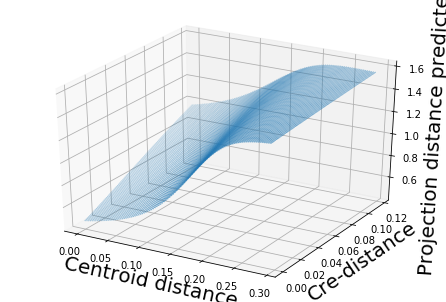

In [17]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[0]].loss_surface)

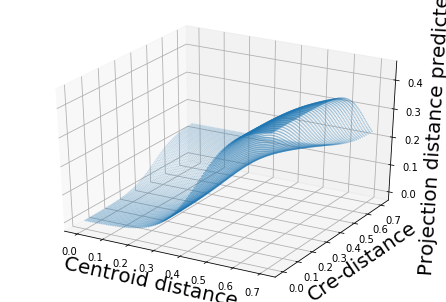

In [18]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[1]].loss_surface)

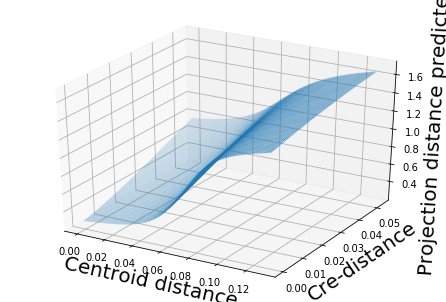

In [19]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[2]].loss_surface)

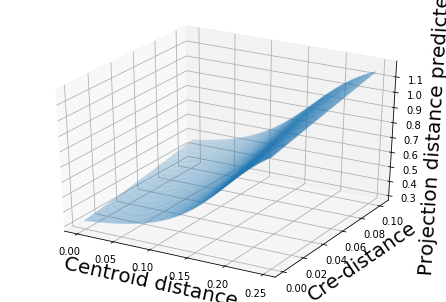

In [20]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[3]].loss_surface)

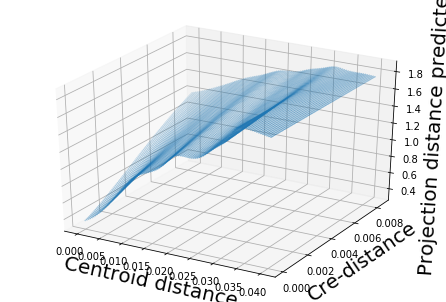

In [21]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface)

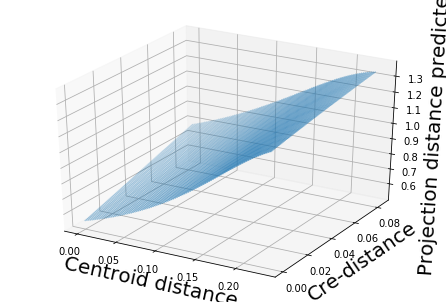

In [32]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[5]].loss_surface)

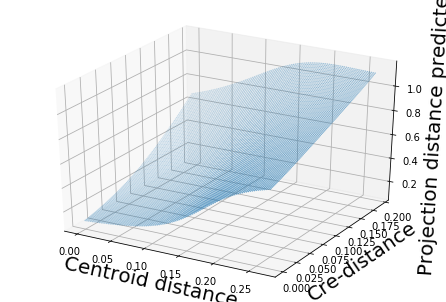

In [33]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[6]].loss_surface)

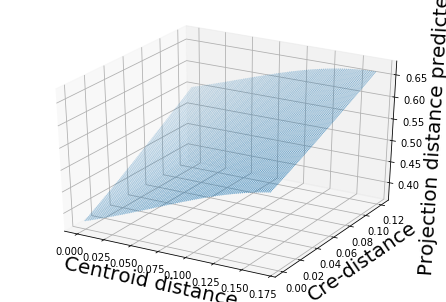

In [34]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[7]].loss_surface)

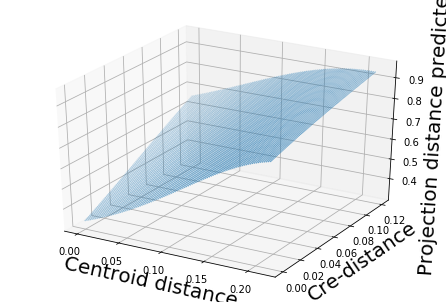

In [35]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[8]].loss_surface)

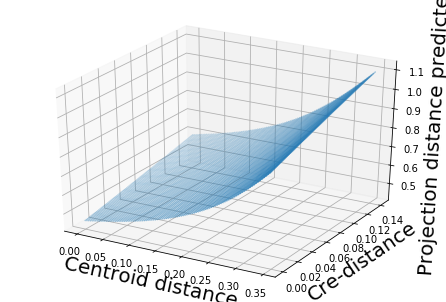

In [36]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[9]].loss_surface)

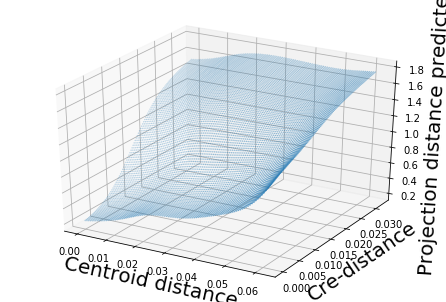

In [37]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[10]].loss_surface)

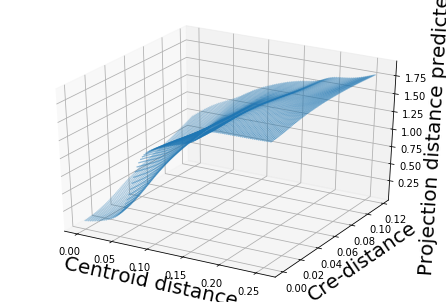

In [38]:
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[11]].loss_surface)

In [39]:
connectivity_data.summarystructure_major_dictionary = get_summarystructure_major_dictionary(connectivity_data)
connectivity_data.major_summarystructure_dictionary = get_major_summarystructure_dictionary(connectivity_data)
connectivity_data.leaf_major_dictionary = get_leaf_major_dictionary(connectivity_data)
connectivity_data.major_leaf_dictionary = get_major_leaf_dictionary(connectivity_data)

In [40]:
#source_ordering_isocortex

In [41]:
    #cre = 
crelist = ['C57BL/6J', 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']##
    #cre = #

In [42]:
ool = np.asarray(ontological_order_leaves, dtype = int)

ool_name = np.asarray([ia_map[ool[i]] for i in range(len(ool))])

In [43]:
ool_name[np.where(np.asarray([np.isin(ool_name[i][:4] ,np.asarray(['VISp', 'VISl'])) for i in range(len(ool))]))[0]]

array(['VISl1', 'VISl2/3', 'VISl4', 'VISl5', 'VISl6a', 'VISl6b', 'VISp1',
       'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b', 'VISpl1',
       'VISpl2/3', 'VISpl4', 'VISpl5', 'VISpl6a', 'VISpl6b', 'VISpm1',
       'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b', 'VISli1',
       'VISli2/3', 'VISli4', 'VISli5', 'VISli6a', 'VISli6b', 'VISpor1',
       'VISpor2/3', 'VISpor4', 'VISpor5', 'VISpor6a', 'VISpor6b'],
      dtype='<U10')

In [44]:
indis = np.where(np.asarray([np.isin(ool_name[i][:4] ,np.asarray(['VISp', 'VISl'])) for i in range(len(ool))]))[0]

In [45]:
indis_2 =np.where(np.isin(ool[indis],np.asarray(list(connectivity_data.leaf_major_dictionary.keys()))))[0]

In [46]:
ool_vispl = ool[indis[indis_2]]

In [47]:
nmnmn = np.asarray([ia_map[connectivity_data.structure_datas[315].leafs[i]] for i in range(connectivity_data.structure_datas[315].leafs.shape[0])])

In [48]:
tergs = np.concatenate([connectivity_data.major_summarystructure_dictionary[315],connectivity_data.major_summarystructure_dictionary[549]])

In [49]:
targ_subset_id = np.where(np.isin(ontological_order,tergs))[0]

In [50]:
connectivity_matrices = get_connectivity_matrices(connectivity_data, crelist, structure_dict = leafs,source_ordering = ool_vispl,target_ordering= ontological_order, structure_major_dictionary = connectivity_data.leaf_major_dictionary, gamma = 10)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [51]:
rownames = np.asarray([ia_map[ool_vispl[i]] for i in range(len(ool_vispl))])
colnames = np.asarray([ia_map[ontological_order[targ_subset_id[i]]] for i in range(len(targ_subset_id))])

Text(0.5, 1, 'C57BL/6J')

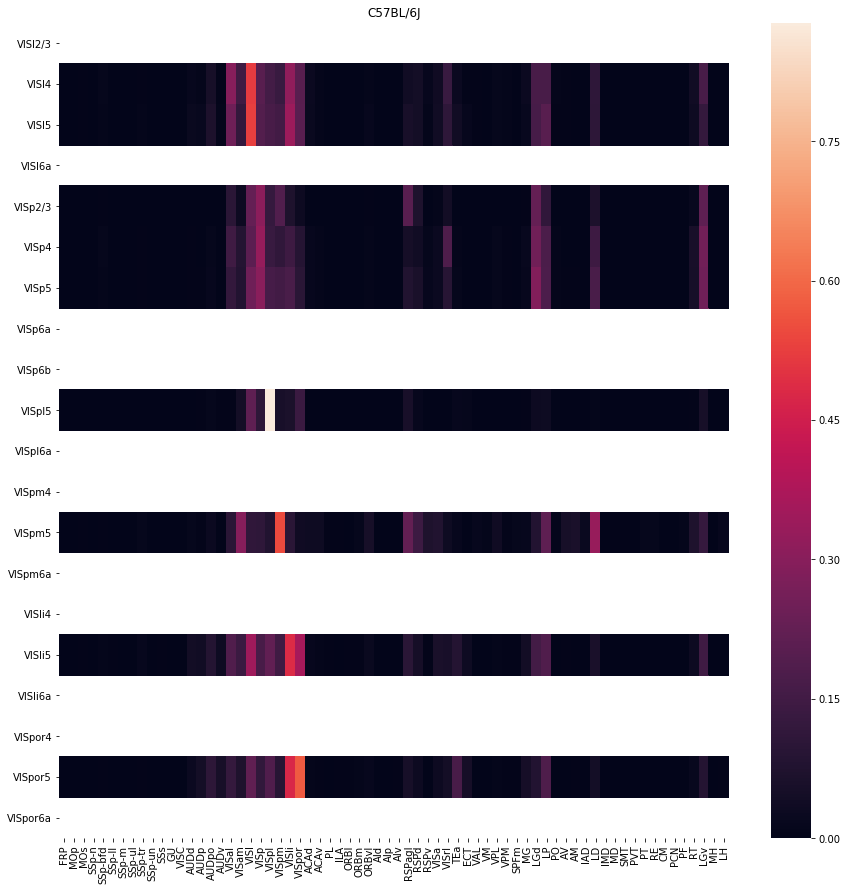

In [52]:
fig, ax = plt.subplots(1,1,figsize = (15,15))
c  = 0
sns.heatmap(connectivity_matrices[c][:, targ_subset_id], xticklabels = colnames, yticklabels = rownames)
plt.title(crelist[c])

Text(0.5, 1, 'Cux2-IRES-Cre')

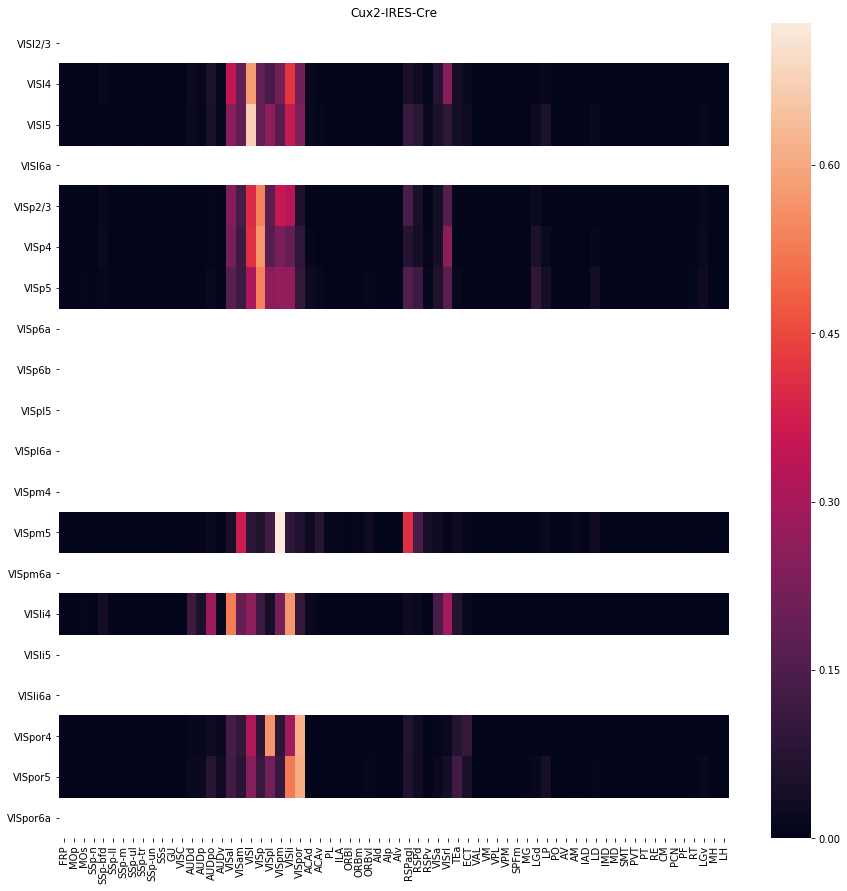

In [53]:
fig, ax = plt.subplots(1,1,figsize = (15,15))
c  = 1
sns.heatmap(connectivity_matrices[c][:, targ_subset_id], xticklabels = colnames, yticklabels = rownames)
plt.title(crelist[c])

Text(0.5, 1, 'Ntsr1-Cre_GN220')

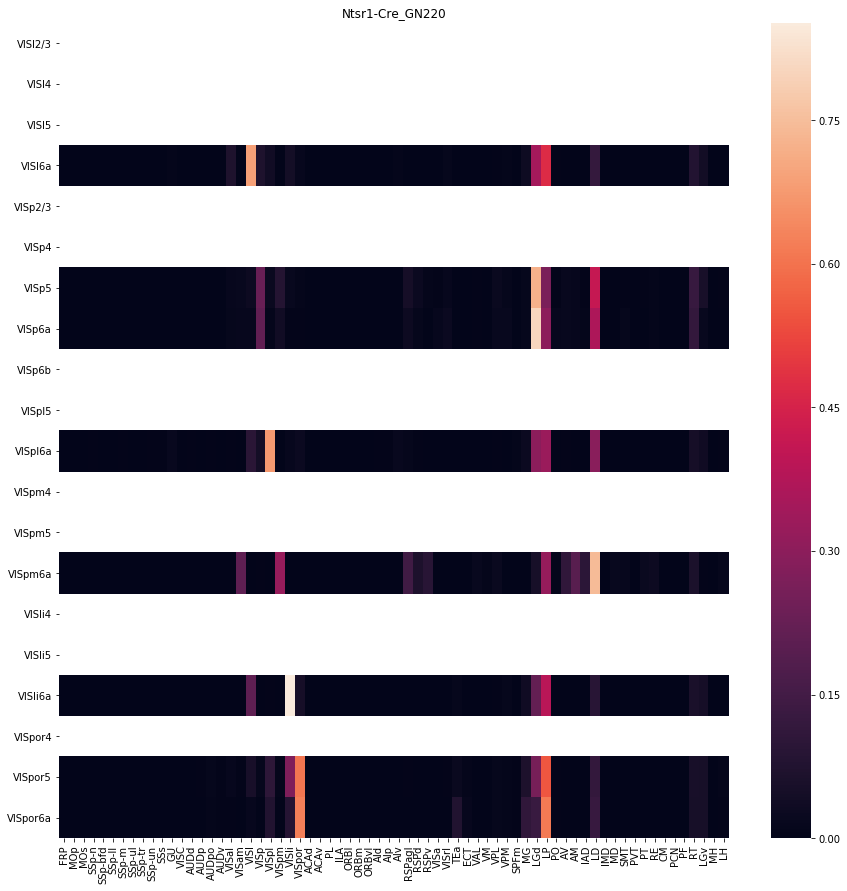

In [54]:
fig, ax = plt.subplots(1,1,figsize = (15,15))
c  = 2
sns.heatmap(connectivity_matrices[c][:, targ_subset_id], xticklabels = colnames, yticklabels = rownames)
plt.title(crelist[c])

Text(0.5, 1, 'Rbp4-Cre_KL100')

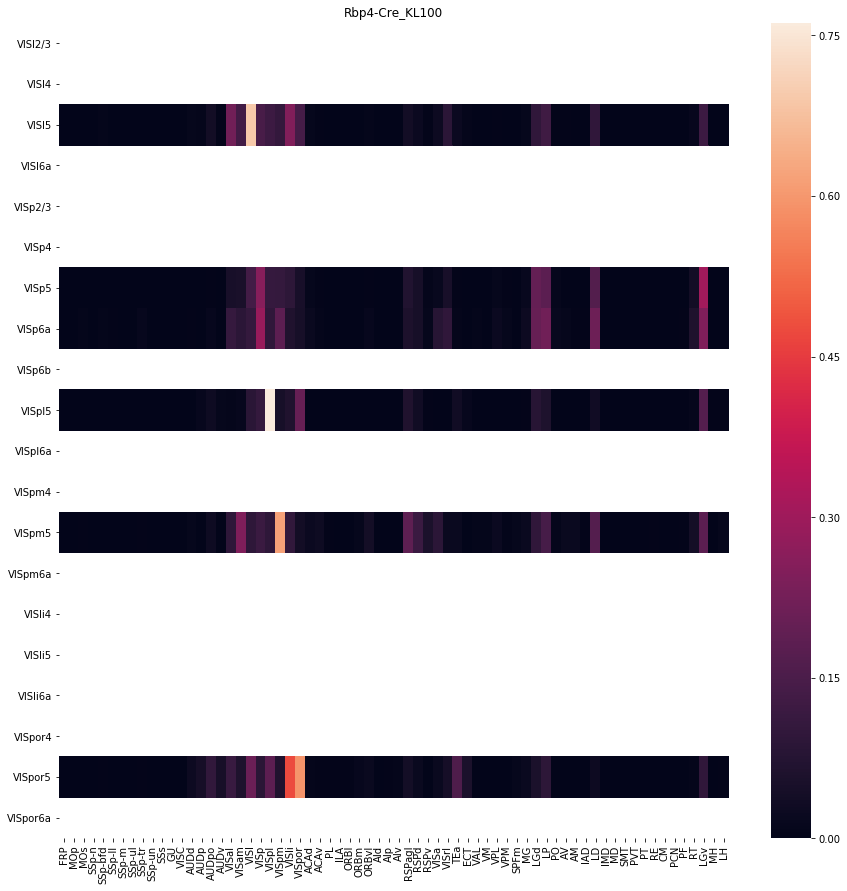

In [55]:
fig, ax = plt.subplots(1,1,figsize = (15,15))
c  = 3
sns.heatmap(connectivity_matrices[c][:, targ_subset_id], xticklabels = colnames, yticklabels = rownames)
plt.title(crelist[c])

Text(0.5, 1, 'Tlx3-Cre_PL56')

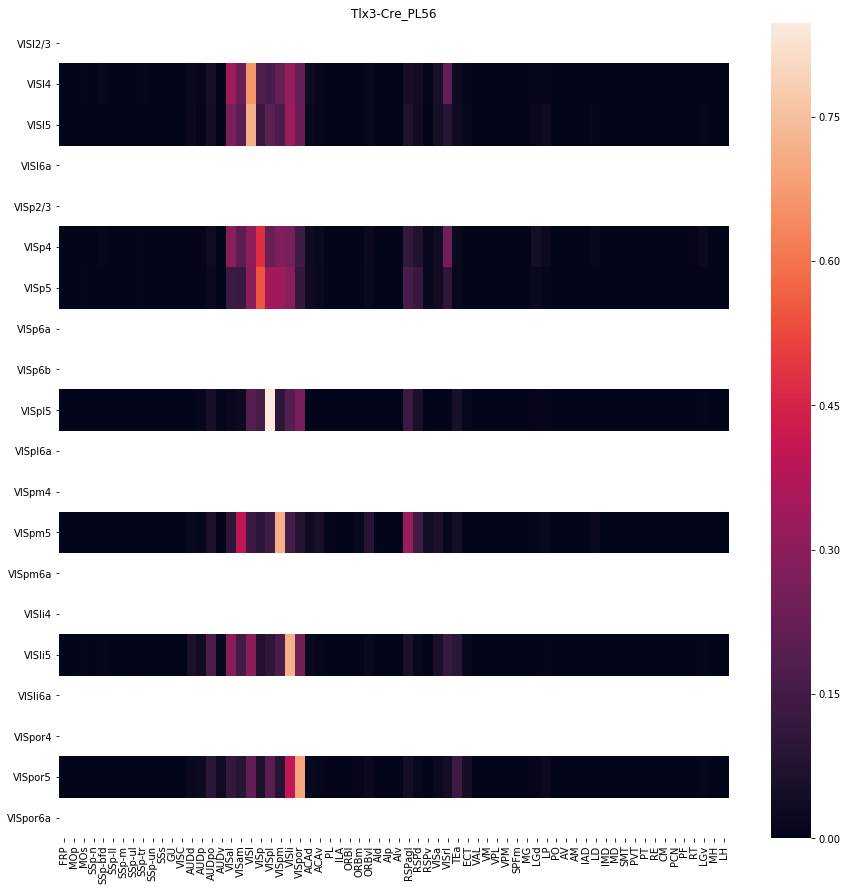

In [56]:
fig, ax = plt.subplots(1,1,figsize = (15,15))
c  = 4
sns.heatmap(connectivity_matrices[c][:, targ_subset_id], xticklabels = colnames, yticklabels = rownames)
plt.title(crelist[c])

In [137]:
np.linalg.norm(connectivity_matrices[0], axis = 1)

array([       nan, 0.96145182, 0.92957558,        nan, 0.88489216,
       0.92495369, 0.89828753,        nan,        nan, 0.96775897,
              nan,        nan, 0.95034668,        nan,        nan,
       0.9722433 ,        nan,        nan, 0.94201343,        nan])

In [138]:
np.linalg.norm(connectivity_data.structure_datas[315].reg_proj_vcount_norm_renorm, axis = 1)

array([1., 1., 1., ..., 1., 1., 1.])

In [139]:
cres = crelist[:1]
structure_dict = leafs
source_ordering = ool_vispl
target_ordering= ontological_order
structure_major_dictionary = connectivity_data.leaf_major_dictionary
gamma = 10

#def get_connectivity_matrices(connectivity_data, cres, structure_dict, source_ordering, target_ordering, structure_major_dictionary,gamma):

nsource = len(source_ordering)
#n#target = len(target_ordering)
ncre = len(cres)

ipsi_target_regions = connectivity_data.ipsi_target_regions
contra_target_regions = connectivity_data.contra_target_regions     

ipsi_indices= np.asarray([])
contra_indices = np.asarray([])
for iy in target_ordering: 
    #print(iy)
    ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
    contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
contra_indices = np.asarray(contra_indices, dtype = int)   

#reorder = np.concatenate([ipsi_indices, contra_indices])  
reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  

ntarget = len(reorder)

connectivity = np.zeros((ncre, nsource, ntarget))
connectivity[:] = np.nan
#structure_major_dictionary = connectivity_data.structure_major_dictionary
#for c in range(ncre):
#    for i in range(nsource):
c = 0
i = 1
print(i)
sid = structure_major_dictionary[source_ordering[i]]
connectivity[c,i] = get_region_prediction
(cache, connectivity_data.structure_datas[sid], structures = structure_dict[sid], prediction_region=source_ordering[i], cre = cres[c], gamma = gamma, surface = connectivity_data.structure_datas[sid].loss_surface, cre_model = True)

connectivity = connectivity[:,:,reorder]                                                  

#    return(connectivity)

SyntaxError: invalid syntax (<ipython-input-139-de5c495678f8>, line 41)

In [140]:
structure_data = connectivity_data.structure_datas[sid]
structures = structure_dict[sid]
prediction_region=source_ordering[i]
cre = cres[c]
gamma = gamma
surface = connectivity_data.structure_datas[sid].loss_surface
cre_model = True


In [141]:

    #def get_region_prediction(cache, structure_data,  structures, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    leaf_experiments = np.where(structures == prediction_region)[0]
    nexp = len(leaf_experiments)
    centroids = structure_data.centroids[leaf_experiments]
    cres = structure_data.crelines[leaf_experiments]
    projections = structure_data.reg_proj_vcount_norm_renorm[leaf_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

    if surface != None and cre_model != True:
        means = get_means(projections,cres, np.repeat(prediction_region,nexp))
        
        losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[prediction_region])
        predictions = get_nw_predictions(projections, losses, gamma)
        output = np.mean(predictions, axis = 0)
        
    if surface != None and cre_model == True:
        means = get_means(projections, cres, np.repeat(prediction_region,nexp))
        #print(means)
        if np.isin(cre, np.asarray(list(means[prediction_region].keys()))):
            losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[prediction_region])
            predictions = get_nw_predictions(projections, losses, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan
            
    if surface == None and cre_model != True:
        means = get_means(projections, cres, [prediction_region])
        predictions = means[cres]
        output = np.mean(predictions, axis = 0)
        
    if surface == None and cre_model == True:
        predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
        output = np.mean(predictions, axis = 0)
        

In [142]:
np.linalg.norm(output)

0.9562433654333369

In [143]:
np.linalg.norm(predictions, axis = 1)

array([0.95532049, 0.95512335, 0.95492939, 0.95537009, 0.95521978,
       0.9550077 , 0.95485651, 0.954623  , 0.95421062, 0.95393158,
       0.95375913, 0.95538911, 0.95516046, 0.95504969, 0.9548026 ,
       0.95442227, 0.95400845, 0.95562299, 0.95537862, 0.95530365,
       0.95504508, 0.95497306, 0.95469553, 0.95462495, 0.95432038,
       0.95424862, 0.9558829 , 0.95561791, 0.95558672, 0.95531274,
       0.95502835, 0.95500038, 0.95469292, 0.95467059, 0.95628035,
       0.95599818, 0.95600198, 0.95571693, 0.95573463, 0.95543979,
       0.95547193, 0.9551584 , 0.9568026 , 0.95649614, 0.95619779,
       0.95625712, 0.95595579, 0.95603741, 0.95572398, 0.95582936,
       0.95741863, 0.95708825, 0.95719412, 0.95687593, 0.95701263,
       0.95669865, 0.95654822, 0.95780323, 0.9583184 , 0.95795217,
       0.95761429, 0.95780183, 0.95747621, 0.95770354, 0.95737958,
       0.9576436 , 0.95926215, 0.95886037, 0.95910308, 0.95873319,
       0.95902128, 0.9586711 , 0.95865266, 0.96038621, 0.96067

In [144]:
np.linalg.norm(projections, axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [145]:
losses

array([[0.43242882, 0.4252638 , 0.42680944, ..., 0.38822458, 0.38727313,
        0.38855212],
       [0.79792851, 0.79737186, 0.7982892 , ..., 0.95194238, 0.96122109,
        0.96286593],
       [0.58392568, 0.57516451, 0.56848597, ..., 0.56557504, 0.58808925,
        0.58104669],
       ...,
       [0.53497603, 0.52893034, 0.52883855, ..., 0.55846343, 0.56725755,
        0.56714821],
       [0.64105475, 0.64064742, 0.64023799, ..., 0.78819355, 0.80094769,
        0.80022541],
       [0.53419043, 0.53258286, 0.53261915, ..., 0.61957483, 0.62647547,
        0.62652926]])

In [148]:
get_nw_predictions(projections, losses, gamma)

dists = losses

#def get_nw_predictions(projections, dists, gamma):
  
     
projections = np.asarray(projections, dtype=np.float32)
neval = dists.shape[1]
#nexp = centroids.shape[0]
predictions = np.zeros((neval, projections.shape[1]))
predictions[:] = np.nan

#print(model_index_val.shape, eval_index_val.shape)
#weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
#for i in range(neval):
i = 1
dists_i = dists[:,i] - np.min(dists[:,i])
#dists_i = dists[i,:] - np.min(dists[i,:])
weights_i = np.exp(- dists_i * gamma)
weights_i = np.asarray(weights_i, dtype=np.float32)
weights_i[np.isnan(weights_i)] = 0.
weights_i = weights_i / np.sum(weights_i)
predictions[i] = np.dot(weights_i, projections)

#    return(predictions) 


In [149]:
weights_i

array([0.19040006, 0.00460917, 0.0425262 , 0.01347254, 0.05837204,
       0.07554   , 0.07070229, 0.35319945, 0.00285152, 0.02331215,
       0.01029757, 0.06752258, 0.02209367, 0.0651008 ], dtype=float32)

In [130]:
np.linalg.norm(predictions[i])

0.9199527728716004

In [128]:
np.linalg.norm(projections, axis = 1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999994, 0.99999994,
       1.        , 1.        , 1.        , 1.        ], dtype=float32)

In [129]:
np.sum(weights_i)

0.9999999

In [131]:
np.linalg.norm(np.dot(weights_i, projections))

0.9199528

$\|\sum_j w_{ij} v_j \| = \sum_j w_{ij} \|v_j\|$